<a href="https://colab.research.google.com/github/JaimeAndresSalas/DynamicOptimization/blob/master/ModelFormulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

apm 35.233.227.73_gk_model0 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 0.9.2
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            4
   Variables    :           21
   Intermediates:            7
   Connections  :            0
   Equations    :           19
   Residuals    :           12
 
 Number of state variables:            192
 Number of total equations: -          192
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 **********************************************
 Dynamic Simulation with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program contains I

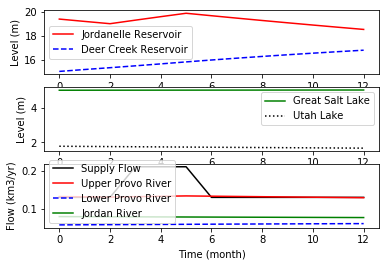

In [3]:
from __future__ import division
from gekko import GEKKO
import numpy as np

#Initial conditions
c = np.array([0.03,0.015,0.06,0])
areas = np.array([13.4, 12, 384.5, 4400])
V0 = np.array([0.26, 0.18, 0.68, 22])
h0 = 1000 * V0 / areas
Vout0 = c * np.sqrt(h0)
vin = [0.13,0.13,0.13,0.21,0.21,0.21,0.13,\
       0.13,0.13,0.13,0.13,0.13,0.13]
Vin = [0,0,0,0]

#Initialize model
m = GEKKO()

#time array 
m.time = np.linspace(0,1,13)
#define constants
c = m.Array(m.Const,4,value=0)
c[0].value = 0.03
c[1].value = c[0] / 2
c[2].value = c[0] * 2
c[3].value = 0
Vuse = [0.03,0.05,0.02,0.00]

#Parameters
evap_c = m.Array(m.Param,4,value=1e-5)
evap_c[-1].value = 0.5e-5

A = [m.Param(value=i) for i in areas]

Vin[0] = m.Param(value=vin)

#Variables
V = [m.Var(value=i) for i in V0]
h = [m.Var(value=i) for i in h0]
Vout = [m.Var(value=i) for i in Vout0]

#Intermediates
Vin[1:4] = [m.Intermediate(Vout[i]) for i in range(3)]
Vevap = [m.Intermediate(evap_c[i] * A[i]) for i in range(4)]

#Equations
m.Equations([V[i].dt() == \
             Vin[i] - Vout[i] - Vevap[i] - Vuse[i] \
             for i in range(4)])
m.Equations([1000*V[i] == h[i]*A[i] for i in range(4)])
m.Equations([Vout[i]**2 == c[i]**2 * h[i] for i in range(4)])


#Set to simulation mode
m.options.imode = 4

#Solve
m.solve()

#%% Plot results
time = [x * 12 for x in m.time] 

# plot results
import matplotlib.pyplot as plt
plt.figure(1)

plt.subplot(311)
plt.plot(time,h[0].value,'r-')
plt.plot(time,h[1].value,'b--')
plt.ylabel('Level (m)')
plt.legend(['Jordanelle Reservoir','Deer Creek Reservoir'])

plt.subplot(312)
plt.plot(time,h[3].value,'g-')
plt.plot(time,h[2].value,'k:')
plt.ylabel('Level (m)')
plt.legend(['Great Salt Lake','Utah Lake'])

plt.subplot(313)
plt.plot(time,Vin[0].value,'k-')
plt.plot(time,Vout[0].value,'r-')
plt.plot(time,Vout[1].value,'b--')
plt.plot(time,Vout[2].value,'g-')
plt.xlabel('Time (month)')
plt.ylabel('Flow (km3/yr)')
plt.legend(['Supply Flow','Upper Provo River', \
            'Lower Provo River','Jordan River'])
plt.show()